In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline


In [2]:
import sys
sys.path.append('/home/courtney/voxelmorph/src')
import os
import glob
import sys
import random
from argparse import ArgumentParser
import time

# third-party imports
import tensorflow as tf
import numpy as np
from keras.backend.tensorflow_backend import set_session
from keras.optimizers import Adam
from keras.models import load_model, Model
from keras.losses import mean_squared_error
import keras.backend as K
from neuron.plot import slices
import scipy.io as sio
from scipy.interpolate import interpn
import matplotlib.pyplot as plt

# project imports
sys.path.append('../ext/medipy-lib')
import medipy
import networks
from medipy.metrics import dice
import datagenerators
import losses
from restrict import restrict_GPU_tf, restrict_GPU_keras

Using TensorFlow backend.


In [3]:
def restrict_GPU_tf(gpuid, memfrac=0, use_cpu=False):
    """
        gpuid: str, comma separated list "0" or "0,1" or even "0,1,3"
        memfrac: float, fraction of memory. By default grows dynamically
    """
    if not use_cpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

        config = tf.ConfigProto()
        if memfrac == 0:
            config.gpu_options.allow_growth = True
        else:
            config.gpu_options.per_process_gpu_memory_fraction = memfrac
        tf.Session(config=config)
        print("Using GPU:{} with {:.0f}% of the memory".format(gpuid, memfrac*100))
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        print("Using CPU")

In [4]:
# Keras 
def restrict_GPU_keras(gpuid, memfrac=0, use_cpu=False):
    """
        gpuid: str, comma separated list "0" or "0,1" or even "0,1,3"
        memfrac: float, fraction of memory. By default grows dynamically
    """
    if not use_cpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

        config = tf.ConfigProto()
        if memfrac == 0:
            config.gpu_options.allow_growth = True
        else:
            config.gpu_options.per_process_gpu_memory_fraction = memfrac
        set_session(tf.Session(config=config))
        print("Using GPU:{} with {:.0f}% of the memory".format(gpuid, memfrac*100))
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        print("Using CPU")

In [5]:
def create_graph(model_name, iter_num, step_size, gpu_id, n_test, invert_images=False, max_clip=0.7):    
    test_brain_file = open('../src/val_files.txt')
    test_brain_strings = test_brain_file.readlines()
    test_brain_strings = [x.strip() for x in test_brain_strings]
    n_batches = len(test_brain_strings)
    good_labels = sio.loadmat('../data/labels.mat')['labels'][0]
    
    # setup
    gpu = '/gpu:' + str(gpu_id)
    #     print(gpu)
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

    restrict_GPU_tf(str(gpu_id))
    restrict_GPU_keras(str(gpu_id))

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    set_session(tf.Session(config=config))

    vol_size=(160,192,224)
    nf_enc=[16,32,32,32]
    nf_dec=[32,32,32,32,32,16,16]
    
    atlas = np.load('../data/atlas_norm.npz')
    atlas_vol = atlas['vol']
    atlas_seg = atlas['seg']
    atlas_vol = np.reshape(atlas_vol, (1,)+atlas_vol.shape+(1,))

    images = []
    for step in range(0, n_test):
        vol_name, seg_name = test_brain_strings[step].split(",")
        X_vol, X_seg = datagenerators.load_example_by_name(vol_name, seg_name)
        images.append([X_vol, X_seg])

    sz = atlas_seg.shape
    z_inp1 = tf.placeholder(tf.float32, sz)
    z_inp2 = tf.placeholder(tf.float32, sz)
    z_out = losses.kdice(z_inp1, z_inp2, good_labels)
    kdice_fn = K.function([z_inp1, z_inp2], [z_out])

    nn_trf_model = networks.nn_trf(vol_size)
    
    dices = []
    for i in range(iter_num//step_size + 1):
        print(i)
        start_time = time.time()

        # load weights of model
        with tf.device(gpu):
            net = networks.unet(vol_size, nf_enc, nf_dec)
            net.load_weights('../models/' + model_name +
                             '/' + str(i*step_size) + '.h5')

        print('model loaded', time.time()-start_time)
        dice_means = []

        for step in range(0, n_test):
            X_vol, X_seg = images[step]
            if invert_images:
                X_vol = max_clip - X_vol

            with tf.device(gpu):
                pred = net.predict([X_vol, atlas_vol])
                warp_seg = nn_trf_model.predict([X_seg, pred[1]])
                mean = np.mean(kdice_fn([warp_seg[0,:,:,:,0], atlas_seg]))
                dice_means.append(mean)

        print('tested patients', time.time()-start_time)
        dices.append(np.mean(dice_means))
    return dices

In [ ]:
dices = create_graph('mi_local2', 100000, 5000, 2, 10, invert_images=True)

Using GPU:2 with 0% of the memory
Using GPU:2 with 0% of the memory
0
model loaded 0.8439362049102783
tested patients 34.61430025100708
1
model loaded 1.1374974250793457
tested patients 26.156599521636963
2
model loaded 1.0755887031555176
tested patients 23.44052791595459
3
model loaded 1.4000821113586426
tested patients 24.620100736618042
4
model loaded 1.185152530670166
tested patients 22.666596174240112
5
model loaded 1.4024746417999268
tested patients 24.621910572052002
6
model loaded 1.569000244140625
tested patients 23.902546405792236
7
model loaded 1.270705223083496
tested patients 23.094548225402832
8
model loaded 1.594560146331787
tested patients 23.786319494247437
9
model loaded 1.9217946529388428
tested patients 24.191333532333374
10
model loaded 1.5972752571105957
tested patients 24.88058590888977
11
model loaded 1.6403043270111084
tested patients 24.0416042804718
12
model loaded 2.007080316543579
tested patients 24.84959387779236
13
model loaded 1.916090726852417
tested pa

/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


(0.725, 0.745)

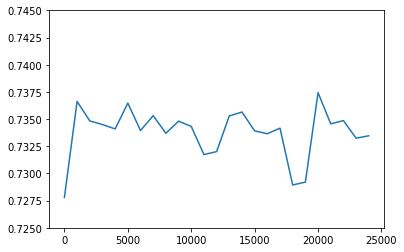

In [10]:
plt.plot(np.linspace(0, 24000, 24000/1000+1), dices)
plt.ylim(0.725, 0.745)

/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


(0.72, 0.75)

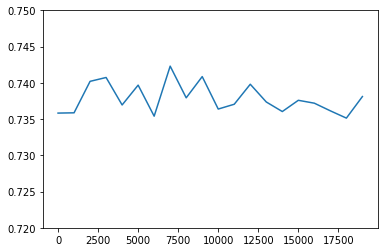

In [7]:
plt.plot(np.linspace(0, 19000, 19000/1000+1), dices)
plt.ylim(0.72, 0.75)

(0.68, 0.72)

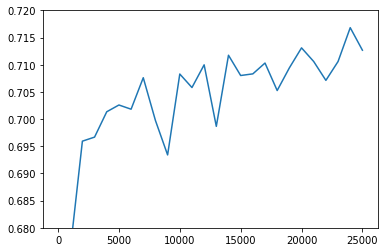

In [20]:
plt.plot(np.linspace(0, 25000, 26), dices)
plt.ylim(0.68, 0.72)

(0.68, 0.7)

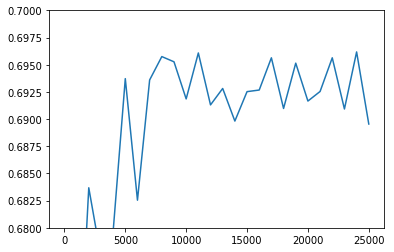

In [19]:
plt.plot(np.linspace(0, 25000, 26), dices)
plt.ylim(0.68, 0.7)

In [21]:
%%time
dices = []
step_size = 5000
for i in range(25000//step_size + 1):
    print(i)
    dices.append(test(model_name, i*step_size, gpu_id, 10, True, 0.7))

0
1
2
3
4
5
CPU times: user 8min 49s, sys: 1min 10s, total: 10min
Wall time: 6min 28s


In [28]:
%%time
dices_2 = []
step_size = 5000
for i in range(iter_num//step_size + 1):
    print(i)
    dices_2.append(test(model_name, i*step_size, gpu_id, 10, False, 0.7))

0
1
2
3
4
5
6
7
8
CPU times: user 13min 28s, sys: 2min 13s, total: 15min 41s
Wall time: 10min 17s


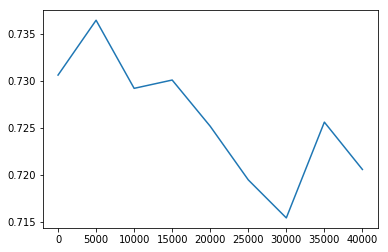

In [30]:
plt.plot([i*step_size for i in range(iter_num//step_size + 1)], dices_2)

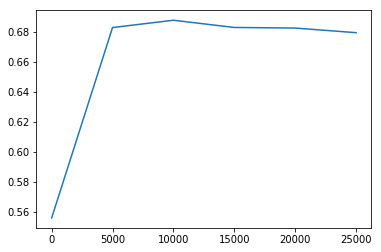

In [31]:
plt.plot([i*step_size for i in range(25000//step_size + 1)], dices)